### Ruben Abbou
## Stiff ODE Solver Based on Backward Euler Method
The error control is done with step doubling i.e. two paths are used to update $\vec{y}$. One uses two steps of size $\frac{dt}{2}$ to produce $d_{new}$ and the other uses a single step of size $dt$ to produce $s_{new}$. Local extrapolation gives a second-order correct method with the approximate solution at $t_{new}$ being $Y_{new} = 2d_{new} − s_{new}$.

$f$ is approximated during each step by an affine function $A(y) = f(w) + Df(w)(y-w)$, where $w$ is the staring value of the backward Euler step.

In [1]:
from numpy.linalg import norm, solve
from numpy import pi, zeros, eye, array, empty, take, argwhere, logical_and
import matplotlib.pyplot as plt
from math import log10
from IPython.display import Markdown
import warnings
warnings.filterwarnings('ignore')

In [2]:
class simTime:
    '''
    Object which encapsulates the information associated with time stepping in an object.
    Inputs:
        - time: start time
        - tol: tolerance
        - endTime: finish time
    '''
    def __init__(self, time, tol, dtmin, dtmax, endTime, agrow=1.25, ashrink=0.8):
        self.time = time
        self.tol = tol
        self.agrow = agrow
        self.ashrink = ashrink
        self.dtmin = dtmin
        self.dtmax = dtmax
        self.dt = self.dtmin
        self.endTime = endTime
        self.stepsSinceRejection = 0
        self.stepsRejected = 0
        self.stepsAccepted = 0
        
    def __str__(self):
        out = "TIME OBJECT REPORT:"
        out += '\n - Tolerance used: {}'.format(self.tol)
        out += '\n - Number of steps accepted: {}'.format(self.stepsAccepted)
        out += '\n - Number of steps rejected: {}'.format(self.stepsRejected)
        return out

In [3]:
def LBE(Y, f, Df, dt):
    return solve(eye(len(Y)) / dt - Df(Y), f(Y))

def step(f, Df, Y_now, dt, v=empty(0)):
    s_new = Y_now + LBE(Y_now, f, Df, dt)
    d_mid = Y_now + LBE(Y_now, f, Df, dt/2)
    d_new = d_mid + LBE(d_mid, f, Df, dt/2)
    
    Y_new = 2 * d_new - s_new
    Af = f(Y_now) + Df(Y_now).dot(Y_new - Y_now)
    
    if not v.any():
        err_step = norm(d_new - s_new)
        err_nonlin = norm(Af - f(Y_new))
    else: # use problem dependent norm
        err_step = sum(abs(d_new - s_new) / v)
        err_nonlin = sum(abs(Af - f(Y_new)) / v)

    err = err_step + err_nonlin
    return Y_new, err, err_step, err_nonlin

def advance(time_obj, Y_now, f, Df, v=empty(0)):
    out = [[Y_now, 0, 0, time_obj.time, log10(time_obj.dt)]]
    while True:
        # do a step
        Y_new, err, err_step, err_nonlin = step(f, Df, Y_now, time_obj.dt, v)
        if err > time_obj.tol and time_obj.dt > time_obj.dtmin:
            # bad step
            time_obj.dt /= 2 #adjust
            time_obj.stepsRejected += 1
            time_obj.stepsSinceRejection = 0
        else:
            # good step
            time_obj.time += time_obj.dt
            Y_now = Y_new
            out.append([Y_now, err_step, err_nonlin, time_obj.time, log10(time_obj.dt)])
            time_obj.stepsSinceRejection += 1
            time_obj.stepsAccepted += 1
            if time_obj.time >= time_obj.endTime:
                break
                
            # time step adjustments
            if time_obj.stepsSinceRejection > 5:
                if err <  time_obj.tol / 4:
                    time_obj.dt *= time_obj.agrow
                if err > 0.75 * time_obj.tol:
                    time_obj.dt *= time_obj.ashrink   
            if time_obj.dt < time_obj.dtmin:
                time_obj.dt = time_obj.dtmin
            if time_obj.dt > time_obj.dtmax:
                time_obj.dt = time_obj.dtmax
            while time_obj.time + time_obj.dt > time_obj.endTime:
                time_obj.dt *= time_obj.ashrink
            if time_obj.time + 2*time_obj.dt > time_obj.endTime and \
                time_obj.time + time_obj.dt < time_obj.endTime:
                time_obj.dt = (time_obj.endTime - time_obj.time) / 2
    return array(out), time_obj

## Stable Circular Orbit

We wish to solve the initial value problem $y(0) = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$ for $t\in[0, 4\pi]$ using the following function:

$$f_{orbit}(y) = \begin{bmatrix} −\alpha(y_0^2 +y_1^2 − 1)y_0 −y_1 \\ y_0−\alpha(y_0^2 +y_1^2 − 1)y_1
\end{bmatrix} $$

$$\Longrightarrow J_{orbit}(y) = \begin{bmatrix} -\alpha\cdot(3y_0^2 +y_1^2-1) & -2\alpha y_0y_1 - 1 \\
1-2\alpha y_0y_1 & -\alpha\cdot(3y_0^2 +y_1^2-1)\end{bmatrix}$$

If $\alpha$ is large the equation is stiff.

#### Case $\alpha = 0.25$

In [4]:
def orbit1(Y):
    alpha = 0.25
    f = zeros(2)
    f[0] = -alpha * (Y[0]**2 + Y[1]**2 - 1) * Y[0] - Y[1]
    f[1] = Y[0] - alpha * (Y[0]**2 + Y[1]**2 - 1) * Y[1]
    return f

def Jorbit1(Y):
    alpha = 0.25
    J = zeros((2,2))
    J[0,0] = -alpha * (3*Y[0]**2 + Y[1]**2 - 1)
    J[0,1] = -alpha * 2 * Y[1] * Y[0] - 1
    J[1,0] = 1 - alpha * 2 * Y[1] * Y[0]
    J[1,1] = -alpha * (3*Y[1]**2 + Y[0]**2 - 1)
    return J

In [5]:
time_obj = simTime(time=0, tol=.001, endTime=4*pi, dtmin=1e-6, dtmax=1.0)
result, time_obj = advance(time_obj, [1,1], orbit1, Jorbit1)
print(time_obj)

TIME OBJECT REPORT:
 - Tolerance used: 0.001
 - Number of steps accepted: 603
 - Number of steps rejected: 0


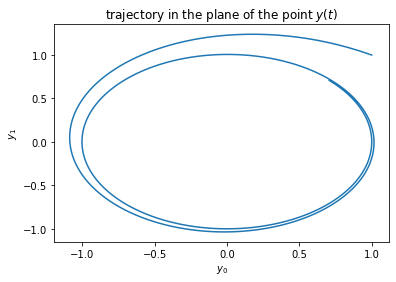

In [6]:
Y = array([x for x in result[:,0]])
plt.plot(Y[:,0], Y[:,1])
plt.title(r'trajectory in the plane of the point $y(t)$')
plt.xlabel(r'$y_0$')
plt.ylabel(r'$y_1$')
plt.show()

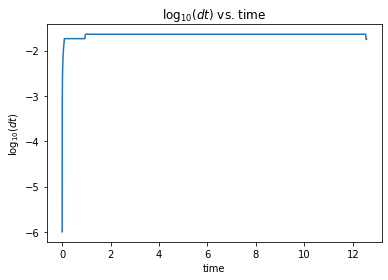

In [7]:
plt.plot(result[:,3], result[:,4])
plt.title(r'$\log_{10}(dt)$ vs. time')
plt.ylabel(r'$\log_{10}(dt)$')
plt.xlabel('time')
plt.show()

#### Case $\alpha = 200$

In [8]:
def orbit2(Y):
    alpha = 200
    f = zeros(2)
    f[0] = -alpha * (Y[0]**2 + Y[1]**2 - 1) * Y[0] - Y[1]
    f[1] = Y[0] - alpha * (Y[0]**2 + Y[1]**2 - 1) * Y[1]
    return f

def Jorbit2(Y):
    alpha = 200
    J = zeros((2,2))
    J[0,0] = -alpha * (3*Y[0]**2 + Y[1]**2 - 1)
    J[0,1] = -alpha * 2 * Y[1] * Y[0] - 1
    J[1,0] = 1 - alpha * 2 * Y[1] * Y[0]
    J[1,1] = -alpha * (3*Y[1]**2 + Y[0]**2 - 1)
    return J

In [9]:
time_obj = simTime(time=0, tol=.001, endTime=4*pi, dtmin=1e-6, dtmax=1.0)
result, time_obj = advance(time_obj, [1,1], orbit2, Jorbit2)
print(time_obj)

TIME OBJECT REPORT:
 - Tolerance used: 0.001
 - Number of steps accepted: 10587
 - Number of steps rejected: 0


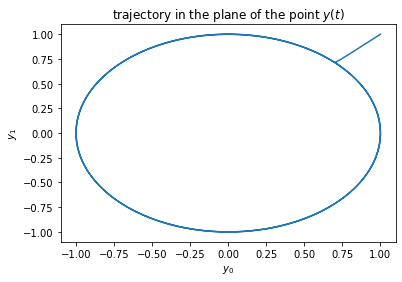

In [10]:
Y = array([x for x in result[:,0]])
plt.plot(Y[:,0], Y[:,1])
plt.title(r'trajectory in the plane of the point $y(t)$')
plt.xlabel(r'$y_0$')
plt.ylabel(r'$y_1$')
plt.show()

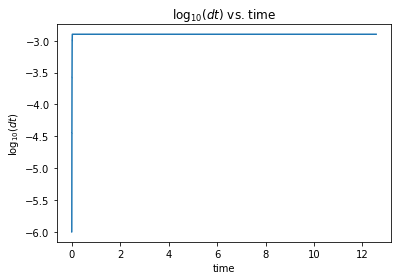

In [11]:
plt.plot(result[:,3], result[:,4])
plt.title(r'$\log_{10}(dt)$ vs. time')
plt.ylabel(r'$\log_{10}(dt)$')
plt.xlabel('time')
plt.show()

## Belousov-Zhabotinsky Reaction Model

We wish to solve the initial value problem $y(0) = \begin{bmatrix} 4 \\ 1.1 \\ 4
\end{bmatrix}$ for $ t\in[0,700]$ using the following function:

$$f_{BZ}(y) = \begin{bmatrix}
77.27(y_1 − y_0y_1 + y_0 − 8.375\cdot 10^{-6} y_0^2) \\
(−y_1 − y_0y_1 + y_2)/77.27 \\
0.161\cdot(y_0 − y_2)
\end{bmatrix}$$

and its Jacobian:
$$J_{BZ}(y) = \begin{bmatrix} 77.27\cdot(-y_1+1-2\cdot 8.357\cdot10^{-6} y_0) & 77.27(-1-y_0) & 0 \\
-y_1/77.27 & (-1-y_0)/77.27 & 1/77.27 \\
0.161 & 0 & -0.161\end{bmatrix}$$

In [12]:
def bz(Y):
    f = zeros(3)
    f[0] = 77.27*(Y[1] - Y[0]*Y[1] + Y[0] - 8.375e-6*Y[0]**2)
    f[1] = (-Y[1] - Y[0]*Y[1] + Y[2])/77.27
    f[2] = 0.161 * (Y[0] - Y[2])
    return f

def Jbz(Y):
    J = zeros((3,3))
    J[0,0] = 77.27*(-Y[1] + 1 - 2 * 8.375e-6 * Y[0])
    J[0,1] = 77.27 * (1 - Y[0])
    
    J[1,0] = -Y[1] / 77.27
    J[1,1] = (-1 - Y[0]) / 77.27
    J[1,2] = 1/77.27
    
    J[2,0] = 0.161
    J[2:2] = -0.161
    return J

TIME OBJECT REPORT:
 - Tolerance used: 1e-06
 - Number of steps accepted: 3510594
 - Number of steps rejected: 0
TIME OBJECT REPORT:
 - Tolerance used: 0.001
 - Number of steps accepted: 7004
 - Number of steps rejected: 23


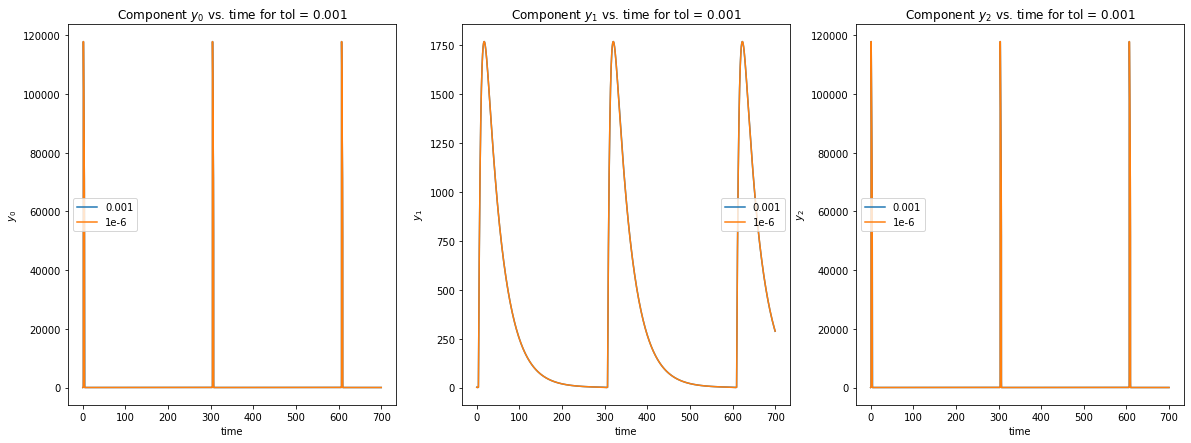

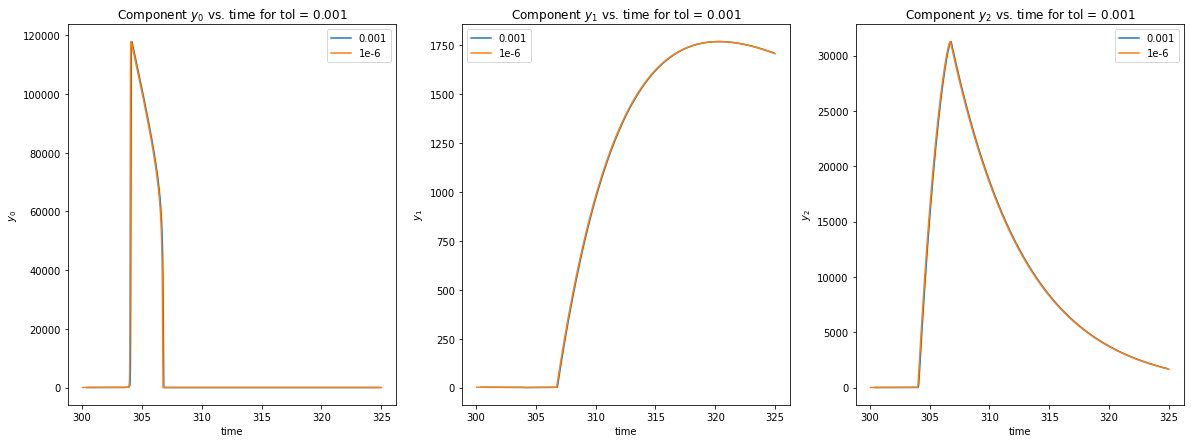

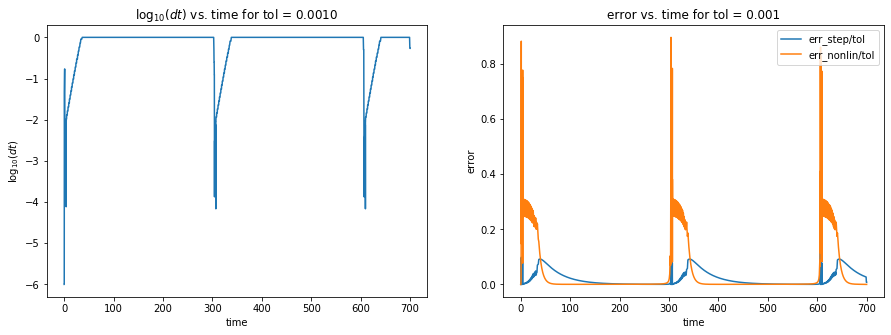

TIME OBJECT REPORT:
 - Tolerance used: 0.0001
 - Number of steps accepted: 44781
 - Number of steps rejected: 18


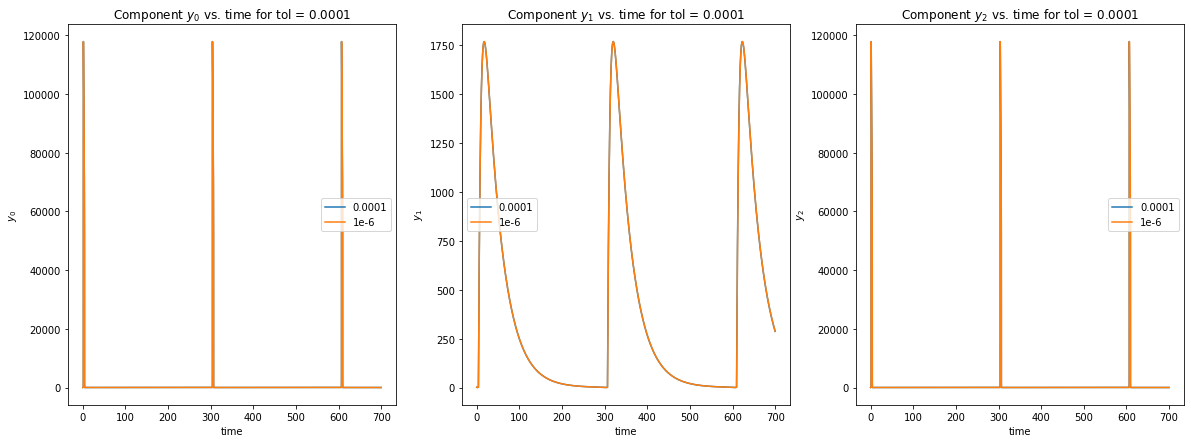

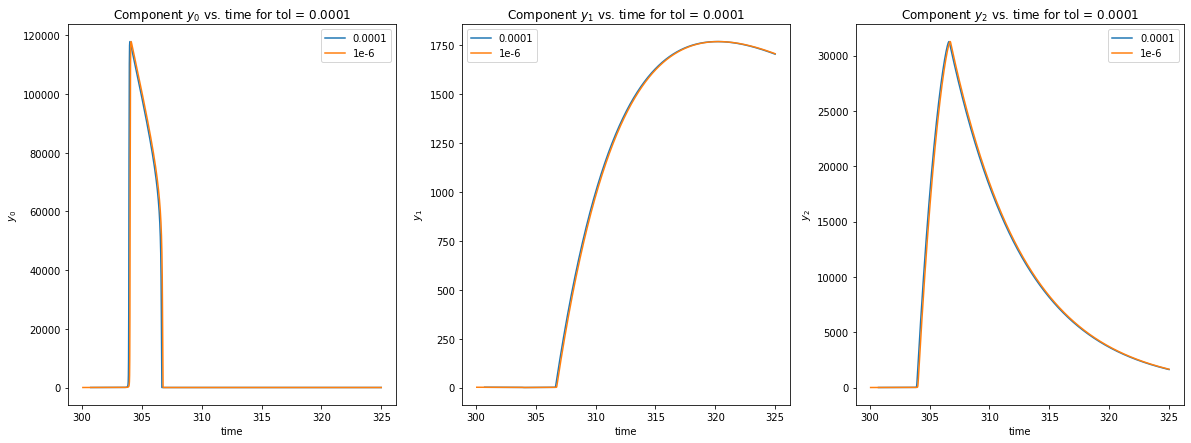

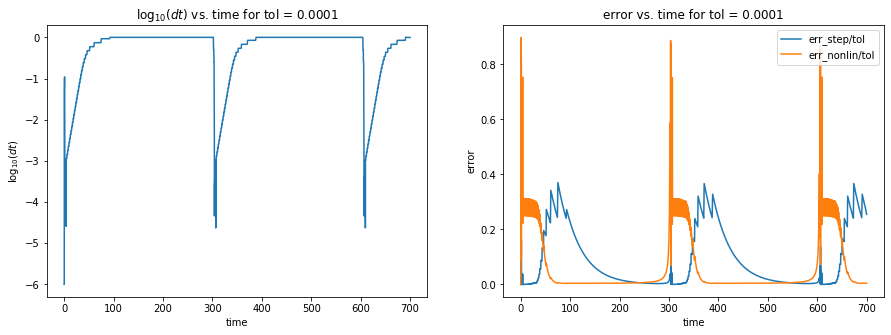

In [13]:
v = array([1.25e5, 1800, 3.0e4])

time_obj = simTime(time=0, tol=1e-6, endTime=700, dtmin=1e-6, dtmax=1.0)
result6, time_obj6 = advance(time_obj, [4,1.1,4], bz, Jbz, v)
t6 = result6[:,3]
y6 = array([x for x in result6[:,0]])
idx6 = argwhere(logical_and(t6 <= 325, t6 >= 300))
print(time_obj6)
objs = [time_obj6]

for tol in [1e-3, 1e-4]:
    time_obj = simTime(time=0, tol=tol, endTime=700, dtmin=1e-6, dtmax=1.0)
    result, time_obj = advance(time_obj, [4,1.1,4], bz, Jbz, v)
    print(time_obj)
    objs.append(time_obj)
    t = result[:,3]
    y = array([x for x in result[:,0]])
    fig = plt.figure(figsize=(20,7))
    
    plt.subplot(1,3,1)
    plt.plot(t, y[:,0], label=tol)
    plt.plot(t6, y6[:,0], label='1e-6')
    plt.legend()
    plt.title(r'Component $y_0$ vs. time for tol = {}'.format(tol))
    plt.xlabel('time')
    plt.ylabel(r'$y_0$')
    
    plt.subplot(1,3,2)
    plt.plot(t, y[:,1], label=tol)
    plt.plot(t6, y6[:,1], label='1e-6')
    plt.legend()
    plt.title(r'Component $y_1$ vs. time for tol = {}'.format(tol))
    plt.xlabel('time')
    plt.ylabel(r'$y_1$')
    
    plt.subplot(1,3,3)
    plt.plot(t, y[:,0], label=tol)
    plt.plot(t6, y6[:,0], label='1e-6')
    plt.legend()
    plt.title(r'Component $y_2$ vs. time for tol = {}'.format(tol))
    plt.xlabel('time')
    plt.ylabel(r'$y_2$')
    plt.show()
    
    idx = argwhere(logical_and(t <= 325, t >= 300))
    
    fig = plt.figure(figsize=(20,7))
    plt.subplot(1,3,1)
    plt.plot(take(t, idx), take(y[:,0], idx), label=tol)
    plt.plot(take(t6, idx6), take(y6[:,0], idx6), label='1e-6')
    plt.legend()
    plt.title(r'Component $y_0$ vs. time for tol = {}'.format(tol))
    plt.xlabel('time')
    plt.ylabel(r'$y_0$')
    
    plt.subplot(1,3,2)
    plt.plot(take(t, idx), take(y[:,1], idx), label=tol)
    plt.plot(take(t6, idx6), take(y6[:,1], idx6), label='1e-6')
    plt.legend()
    plt.title(r'Component $y_1$ vs. time for tol = {}'.format(tol))
    plt.xlabel('time')
    plt.ylabel(r'$y_1$')
    
    plt.subplot(1,3,3)
    plt.plot(take(t, idx), take(y[:,2], idx), label=tol)
    plt.plot(take(t6, idx6), take(y6[:,2], idx6), label='1e-6')
    plt.legend()
    plt.title(r'Component $y_2$ vs. time for tol = {}'.format(tol))
    plt.xlabel('time')
    plt.ylabel(r'$y_2$')
    plt.show()
    
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(t, result[:, 4])
    plt.title(r'$\log_{10}(dt)$ vs. time for tol = %.4f' % tol)
    plt.ylabel(r'$\log_{10}(dt)$')
    plt.xlabel('time')
    
    plt.subplot(1,2,2)
    plt.plot(t, result[:, 1]/tol, label = 'err_step/tol')
    plt.plot(t, result[:, 2]/tol, label = 'err_nonlin/tol')
    plt.title(r'error vs. time for tol = {}'.format(tol))
    plt.ylabel(r'error')
    plt.xlabel('time')
    plt.legend()
    plt.show()

In [14]:
Markdown("""
| Tolerance   | Steps Accepted | Steps Rejected |
| ----------- | -------------- | -------------- |
| $10^{-3}$   | %d             | %d             |
| $10^{-4}$   | %d             | %d             |
| $10^{-6}$   | %d             | %d             |
""" % \
(objs[1].stepsAccepted, objs[1].stepsRejected,
 objs[2].stepsAccepted, objs[2].stepsRejected,
 objs[0].stepsAccepted, objs[0].stepsRejected))


| Tolerance   | Steps Accepted | Steps Rejected |
| ----------- | -------------- | -------------- |
| $10^{-3}$   | 7004             | 23             |
| $10^{-4}$   | 44781             | 18             |
| $10^{-6}$   | 3510594             | 0             |
